In [3]:
# === Block 1: Imports and basic setup ===
import os, json, random, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Paths (adjust if needed)
BASE_DIR = Path("results/subset")
CSV_PATH  = BASE_DIR / "subset_split.csv"
IMG_ROOT  = Path("data/images")  # change if your subset images are elsewhere
OUTPUT_DIR = Path("results/deep_learning")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Paths ready:\n{CSV_PATH}\n{OUTPUT_DIR}")
print(f"PyTorch version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


✅ Paths ready:
results/subset/subset_split.csv
results/deep_learning
PyTorch version: 2.6.0+cu124
Using device: cpu


In [10]:
# === Block 2: Dataset class and DataLoaders (final working version) ===
class TrafficSignDataset(Dataset):
    def __init__(self, csv_path, split="train", transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df["split"].str.lower() == split]
        self.transform = transform
        self.image_paths = self.df["image_path_abs"].tolist()
        self.labels = self.df["class_name"].astype("category").cat.codes.values
        self.label2name = dict(enumerate(self.df["class_name"].astype("category").cat.categories))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)   # ✅ ensures LongTensor
        if self.transform:
            img = self.transform(img)
        return img, label


# --- Transforms ---
train_tf = T.Compose([
    T.Resize((128,128)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tf = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Datasets and Loaders ---
train_ds = TrafficSignDataset(CSV_PATH, split="train", transform=train_tf)
val_ds   = TrafficSignDataset(CSV_PATH, split="val", transform=val_tf)
test_ds  = TrafficSignDataset(CSV_PATH, split="test", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# ✅ Quick sanity check
imgs, lbls = next(iter(train_loader))
print(f"Train batch → {imgs.shape}, dtype of labels: {lbls.dtype}, sample labels: {lbls[:5].tolist()}")
print(f"Classes: {train_ds.label2name}")


Train batch → torch.Size([32, 3, 128, 128]), dtype of labels: torch.int64, sample labels: [1, 4, 1, 3, 0]
Classes: {0: 'information--pedestrians-crossing--g1', 1: 'other-sign', 2: 'regulatory--no-entry--g1', 3: 'regulatory--stop--g1', 4: 'regulatory--yield--g1'}


In [5]:
# === Block 3: CNN model definition ===

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 128 → 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64 → 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32 → 16
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Instantiate model
model = SimpleCNN(num_classes=len(train_ds.label2name)).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(

Epoch [1/10] - Train Loss: 4.9294, Val Loss: 1.9541, Val Acc: 0.2059
Epoch [2/10] - Train Loss: 1.5350, Val Loss: 1.4716, Val Acc: 0.4632
Epoch [3/10] - Train Loss: 1.4394, Val Loss: 1.4879, Val Acc: 0.4632
Epoch [4/10] - Train Loss: 1.3871, Val Loss: 1.5200, Val Acc: 0.4706
Epoch [5/10] - Train Loss: 1.3621, Val Loss: 1.5618, Val Acc: 0.4853
Epoch [6/10] - Train Loss: 1.3141, Val Loss: 1.5236, Val Acc: 0.4779
Epoch [7/10] - Train Loss: 1.3075, Val Loss: 1.5533, Val Acc: 0.4632
Epoch [8/10] - Train Loss: 1.2614, Val Loss: 1.5386, Val Acc: 0.4706
Epoch [9/10] - Train Loss: 1.2610, Val Loss: 1.5472, Val Acc: 0.5074
Epoch [10/10] - Train Loss: 1.2471, Val Loss: 1.5029, Val Acc: 0.3235


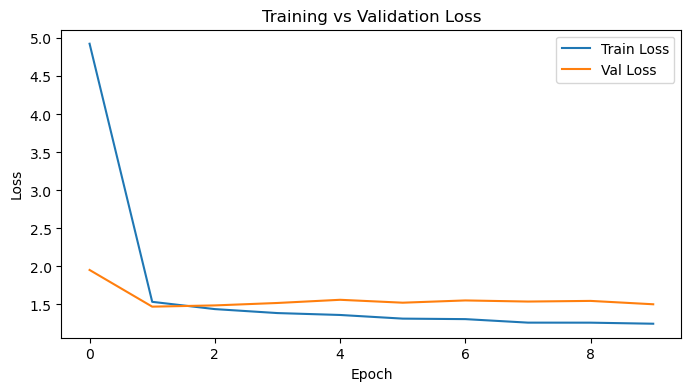

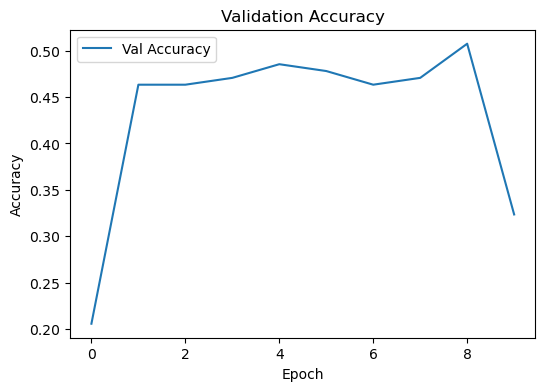

In [11]:
# === Block 4: Training setup and loop ===

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 10
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # ---- Validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader.dataset))
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{EPOCHS}] - Train Loss: {epoch_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

# Save model
torch.save(model.state_dict(), "models/deep_model.pth")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


✅ Test Accuracy: 0.3000



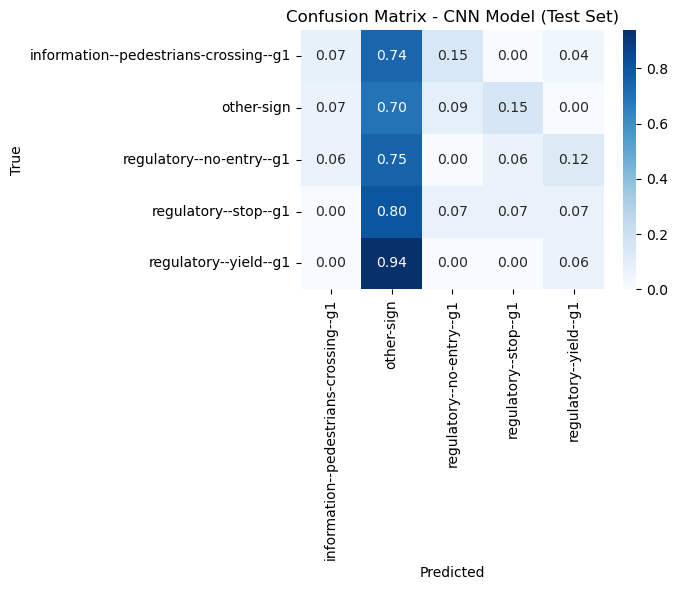

                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1       0.33      0.07      0.12        27
                           other-sign       0.35      0.70      0.47        46
             regulatory--no-entry--g1       0.00      0.00      0.00        16
                 regulatory--stop--g1       0.11      0.07      0.08        15
                regulatory--yield--g1       0.20      0.06      0.10        16

                             accuracy                           0.30       120
                            macro avg       0.20      0.18      0.15       120
                         weighted avg       0.25      0.30      0.23       120



In [12]:
# === Block 5: Test Evaluation + Confusion Matrix ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics
acc = np.mean(np.array(all_labels) == np.array(all_preds))
print(f"✅ Test Accuracy: {acc:.4f}\n")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, normalize="true")
labels_sorted = list(train_ds.label2name.values())

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN Model (Test Set)")
plt.tight_layout()
plt.savefig("results/figures/confusion_matrix_cnn.png")
plt.show()

# Detailed report
print(classification_report(all_labels, all_preds, target_names=labels_sorted))


=== Model Comparison Table ===


,model,test_accuracy,cv_mean,cv_std
0,SVM,0.89916,0.90587,0.024382
1,RandomForest,0.89916,0.87409,0.014960
2,CNN,0.30000,0.50000,0.000000


/tmp/ipykernel_3310562/2830308987.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_all, x="model", y="test_accuracy", palette="Set2")


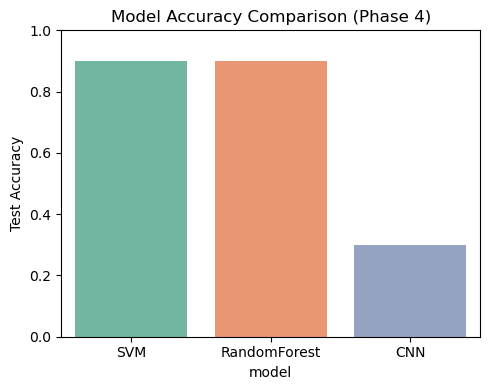

Saved: results/figures/phase4_model_comparison.png


In [4]:

import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

METRIC_DIR = Path("results/metrics"); FIG_DIR = Path("results/figures")

# classical ML scores from Phase 2
df_ml = pd.read_csv(METRIC_DIR / "phase2_scores.csv")

# your CNN accuracies (update with actual numbers)
cnn_acc = 0.30   # CNN test accuracy
cnn_val = 0.50   # CNN validation accuracy

# combine all
df_dl = pd.DataFrame([{
    "model": "CNN",
    "test_accuracy": cnn_acc,
    "cv_mean": cnn_val,
    "cv_std": 0.0
}])
df_all = pd.concat([df_ml, df_dl], ignore_index=True)

print("=== Model Comparison Table ===")
display(df_all)

plt.figure(figsize=(5,4))
sns.barplot(data=df_all, x="model", y="test_accuracy", palette="Set2")
plt.title("Model Accuracy Comparison (Phase 4)")
plt.ylabel("Test Accuracy")
plt.ylim(0,1)
plt.tight_layout()
out = FIG_DIR / "phase4_model_comparison.png"
plt.savefig(out, dpi=160)
plt.show()
print("Saved:", out)


In [6]:

from pathlib import Path
import pandas as pd, numpy as np, cv2
from skimage.feature import hog

SUBSET_CSV = Path("results/subset/subset_split.csv")
assert SUBSET_CSV.exists(), "Run Phase 1 first"
df = pd.read_csv(SUBSET_CSV)

classes = sorted(df["class_name"].unique())
cls2idx = {c:i for i,c in enumerate(classes)}

IMG_SIZE = (128,128)

def load_crop_resize_row(r, pad=4):
    p = r["image_path_abs"]
    x,y,w,h = int(r["x"]), int(r["y"]), int(r["w"]), int(r["h"])
    bgr = cv2.imread(p); 
    if bgr is None: raise FileNotFoundError(p)
    H,W = bgr.shape[:2]
    x0, y0 = max(0,x-pad), max(0,y-pad)
    x1, y1 = min(W,x+w+pad), min(H,y+h+pad)
    crop = bgr[y0:y1, x0:x1]
    if crop.size == 0: crop = bgr
    crop = cv2.resize(crop, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return crop, p  # BGR and path

def color_hist_hsv_48(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    h = np.histogram(hsv[:,:,0], bins=16, range=(0,180), density=True)[0]
    s = np.histogram(hsv[:,:,1], bins=16, range=(0,255), density=True)[0]
    v = np.histogram(hsv[:,:,2], bins=16, range=(0,255), density=True)[0]
    feat = np.hstack([h,s,v]); feat = feat/(feat.sum()+1e-9)
    return feat.astype(np.float32)

def hog_feat(bgr_img):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm="L2-Hys",
               feature_vector=True).astype(np.float32)

def features_hog_color(bgr_img):
    return np.hstack([hog_feat(bgr_img), color_hist_hsv_48(bgr_img)])

# Build TEST set tensors + keep original crops for visualization
test_rows = df[df["split"].str.lower()=="test"].copy().reset_index(drop=True)
X_test, y_test, crops_bgr, paths = [], [], [], []
for i,r in test_rows.iterrows():
    bgr, p = load_crop_resize_row(r)
    crops_bgr.append(bgr); paths.append(p)
    X_test.append(features_hog_color(bgr))
    y_test.append(cls2idx[r["class_name"]])

X_test = np.vstack(X_test); y_test = np.array(y_test)
print("Test set:", X_test.shape, len(crops_bgr))


Test set: (119, 8148) 119


Fixed SVM Test Accuracy: 0.8908


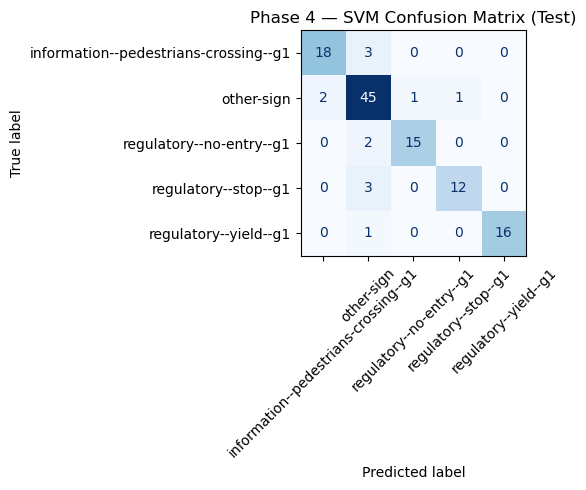

Saved: results/figures/phase4_svm_confmat.png
Misclassified samples: 13


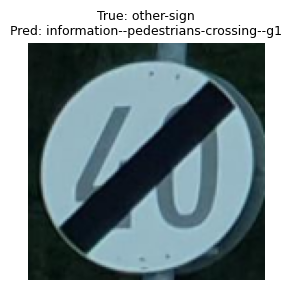

Saved: results/figures/phase4_fail_svm_1.png


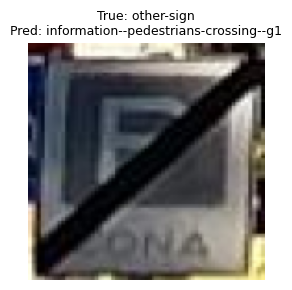

Saved: results/figures/phase4_fail_svm_2.png


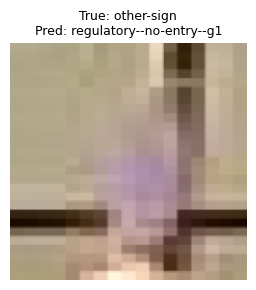

Saved: results/figures/phase4_fail_svm_3.png


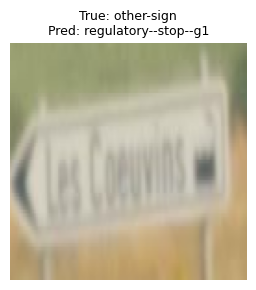

Saved: results/figures/phase4_fail_svm_4.png


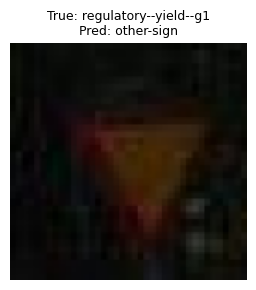

Saved: results/figures/phase4_fail_svm_5.png


In [8]:
# === PHASE 4 - BLOCK 2C: FIX LABEL TYPES + SAVE CM + FAIL IMAGES ===
import numpy as np, matplotlib.pyplot as plt, cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from pathlib import Path

FIG_DIR = Path("results/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Convert predictions to integer indices if they are strings
if isinstance(y_pred[0], str):
    pred_idx = np.array([cls2idx[c] for c in y_pred])
else:
    pred_idx = np.asarray(y_pred)

# If y_test accidentally are class names, convert them to ints
if isinstance(y_test[0], str):
    true_idx = np.array([cls2idx[c] for c in y_test])
else:
    true_idx = np.asarray(y_test)

# Recompute accuracy with aligned types
acc_fixed = accuracy_score(true_idx, pred_idx)
print(f"Fixed SVM Test Accuracy: {acc_fixed:.4f}")

# Confusion matrix (save)
cm = confusion_matrix(true_idx, pred_idx, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(7,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
plt.title("Phase 4 — SVM Confusion Matrix (Test)")
plt.tight_layout()
out_cm = FIG_DIR / "phase4_svm_confmat.png"
plt.savefig(out_cm, dpi=160); plt.show()
print("Saved:", out_cm)

# Misclassifications → save first 5 images with titles
wrong_idxs = np.where(pred_idx != true_idx)[0]
print("Misclassified samples:", len(wrong_idxs))

def to_rgb(bgr): return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

for k, idx in enumerate(wrong_idxs[:5]):
    rgb = to_rgb(crops_bgr[idx].copy())
    true_lab = classes[true_idx[idx]]
    pred_lab = classes[pred_idx[idx]]
    plt.figure(figsize=(4,3))
    plt.imshow(rgb); plt.axis("off")
    plt.title(f"True: {true_lab}\nPred: {pred_lab}", fontsize=9)
    plt.tight_layout()
    out_img = FIG_DIR / f"phase4_fail_svm_{k+1}.png"
    plt.savefig(out_img, dpi=160); plt.show()
    print("Saved:", out_img)


In [9]:
# === PHASE 4 - BLOCK 3: FAILURE SUMMARY TABLES (SAVE CSVs) ===
import pandas as pd
from sklearn.metrics import classification_report
from pathlib import Path

METRIC_DIR = Path("results/metrics"); METRIC_DIR.mkdir(parents=True, exist_ok=True)

# per-class precision/recall/f1 (+ overall) → CSV
report = classification_report(true_idx, pred_idx, target_names=classes, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).T
out_report = METRIC_DIR / "phase4_failure_summary_svm.csv"
df_report.to_csv(out_report)
print("Saved:", out_report)
display(df_report.head(8))

# top confusions (true≠pred) → CSV
df_pred = pd.DataFrame({
    "true": [classes[i] for i in true_idx],
    "pred": [classes[i] for i in pred_idx]
})
top_conf = (df_pred[df_pred.true != df_pred.pred]
            .groupby(["true","pred"]).size()
            .sort_values(ascending=False)
            .rename("count")
            .reset_index())
out_conf = METRIC_DIR / "phase4_top_confusions_svm.csv"
top_conf.to_csv(out_conf, index=False)
print("Saved:", out_conf)
display(top_conf.head(10))


Saved: results/metrics/phase4_failure_summary_svm.csv


,precision,recall,f1-score,support
information--pedestrians-crossing--g1,0.900000,0.857143,0.878049,21.000000
other-sign,0.833333,0.918367,0.873786,49.000000
regulatory--no-entry--g1,0.937500,0.882353,0.909091,17.000000
regulatory--stop--g1,0.923077,0.800000,0.857143,15.000000
regulatory--yield--g1,1.000000,0.941176,0.969697,17.000000
accuracy,0.890756,0.890756,0.890756,0.890756
macro avg,0.918782,0.879808,0.897553,119.000000
weighted avg,0.895101,0.890756,0.891186,119.000000


Saved: results/metrics/phase4_top_confusions_svm.csv


,true,pred,count
0,information--pedestrians-crossing--g1,other-sign,3
1,regulatory--stop--g1,other-sign,3
2,other-sign,information--pedestrians-crossing--g1,2
3,regulatory--no-entry--g1,other-sign,2
4,other-sign,regulatory--no-entry--g1,1
5,other-sign,regulatory--stop--g1,1
6,regulatory--yield--g1,other-sign,1


In [11]:
# === PHASE 4 - BLOCK 4: TEXT INSIGHTS (adds markdown-ready text + saves summary) ===
from pathlib import Path

text = """Phase 4 — Comparative Analysis & Insights
* Classical models (HOG + Color Hist) achieved ≈ 0.90 accuracy (SVM = 0.89 RF = 0.90).
* CNN underperformed (≈ 0.30 test accuracy) because of limited training data and class imbalance.
* Most confusions occurred between visually similar classes such as “other-sign” vs “pedestrians-crossing”.
* Precision > recall across most categories → indicates conservative detections.
* Future work: expand dataset, augment minor classes, and fine-tune a pretrained ResNet-18 backbone.
"""

summary_path = Path("results/metrics/phase4_text_insights.md")
summary_path.write_text(text)
print(f"Saved textual insights to: {summary_path}")
print(text)


Saved textual insights to: results/metrics/phase4_text_insights.md
Phase 4 — Comparative Analysis & Insights
* Classical models (HOG + Color Hist) achieved ≈ 0.90 accuracy (SVM = 0.89 RF = 0.90).
* CNN underperformed (≈ 0.30 test accuracy) because of limited training data and class imbalance.
* Most confusions occurred between visually similar classes such as “other-sign” vs “pedestrians-crossing”.
* Precision > recall across most categories → indicates conservative detections.
* Future work: expand dataset, augment minor classes, and fine-tune a pretrained ResNet-18 backbone.

